# meg prep rewrite

This brings together a bunch of steps into a straight line for simpler use.

Some remaining questions

- invoke brainstorm with MCR
  - still need to automate creating the protocol
  - check the scripts can dump the plain .mat files
- automate clean up when results are done (or not, if we want to keep the protocol)
- sync processed results to s3/hf
- move data to the mode space, short time fourier transform

here you need your own credentials from https://db.humanconnectome.org and put them in
~/.aws/credentials, e.g. 

```ini
[default]
aws_access_key_id=foo
aws_secret_access_key=bar
```

In [12]:
import boto3, os, json

client = boto3.client('s3')
workpath = '/work/duke/hcp-meg'
anat_dir = f'{workpath}/{sid}/anatomy'
raw_dir = f'{workpath}/{sid}/raw'
verbose = False

os.makedirs(anat_dir, exist_ok=True)
os.makedirs(raw_dir, exist_ok=True)



In [35]:
if not verbose:
    print(f'👤 {sid} ', end='', flush=True)

def dl_s3_file(s3path, dlpath, quiet=True):
    if not os.path.exists(dlpath):
        if verbose:
            print('⬇️', dlpath, flush=True)
        else:
            print('⬇️', end='', flush=True)
        client.download_file('hcp-openaccess', s3path, dlpath)
    else:
        if verbose:
            print('⏩', dlpath, flush=True)
        else:
            print('⏩', end='', flush=True)


def make_download_list(sid):
    downloads = []

    anat_objects = client.list_objects(
        Bucket='hcp-openaccess',
        Prefix=f'HCP_1200/{sid}/MEG/anatomy')

    meg_objects = client.list_objects(
        Bucket='hcp-openaccess',
        Prefix=f'HCP_1200/{sid}/unprocessed/MEG')

    for s3obj in anat_objects['Contents']:
        s3path = s3obj['Key']
        dlpath = os.path.join(anat_dir, os.path.basename(s3path))
        downloads.append((s3path, dlpath))

    for obj in meg_objects['Contents']:
        key = obj['Key']
        fname = os.path.basename(key)
        _hcp, _sid, _unproc, _meg, task, _4d = os.path.dirname(key).split(os.sep)
        dlpath = f'{raw_dir}/{task}/{fname}'
        os.makedirs(os.path.dirname(dlpath), exist_ok=True)
        downloads.append((key, dlpath))

    return downloads

downloads = make_download_list(162026)

for s3path, dlpath in downloads:
    dl_s3_file(s3path, dlpath)

👤 162026 ⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩⏩

In [40]:
import tqdm, numpy as np

for sid in tqdm.tqdm(np.loadtxt('hcp-meg-ids.txt', dtype='i')):
    downloads = make_download_list(sid)
    for s3path, dlpath in downloads:
        client.download_file('hcp-openaccess', s3path, dlpath)
        # dl_s3_file(s3path, dlpath)


 31%|███       | 29/95 [2:33:32<4:53:10, 266.52s/it]

<h2> stop! </h2>

we've downloaded the raw files. 

next, configure brainstorm by providing some defaults:

In [7]:
!cd brainstorm3-template-folders/ && bash restore.sh

+ rm -rf /home/duke/.brainstorm
+ rm -rf /tmp/brainstorm_db
+ rm -rf /tmp/brainstorm_temp
+ rsync -rav ./.brainstorm /home/duke/
sending incremental file list
.brainstorm/
.brainstorm/brainstorm.mat
.brainstorm/defaults/
.brainstorm/defaults/anatomy/
.brainstorm/defaults/eeg/
.brainstorm/mex/
.brainstorm/plugins/
.brainstorm/process/
.brainstorm/reports/
.brainstorm/tmp/

sent 98.262 bytes  received 75 bytes  196.674,00 bytes/sec
total size is 97.842  speedup is 0,99
+ rsync -rav ./brainstorm_db /tmp/
sending incremental file list
brainstorm_db/
brainstorm_db/hcp/
brainstorm_db/hcp/anat/
brainstorm_db/hcp/anat/@default_subject/
brainstorm_db/hcp/anat/@default_subject/brainstormsubject.mat
brainstorm_db/hcp/anat/@default_subject/subjectimage_ASEG_volatlas.mat
brainstorm_db/hcp/anat/@default_subject/subjectimage_DKT_volatlas.mat
brainstorm_db/hcp/anat/@default_subject/subjectimage_Deskian-Killiany_volatlas.mat
brainstorm_db/hcp/anat/@default_subject/subjectimage_Destrieux_volatlas.mat
br

this puts a config file telling brainstorm our DB is in /tmp & provides a default HCP protocol.

go run `megfield_pp0_new_subject` and `megfield_pp2` and the export function seem to run fine.

In [9]:
!./brainstorm3-versions/231208/brainstorm3/bin/R2022b/brainstorm3.command /usr/local/MATLAB/MATLAB_Runtime/R2022b megfield_pp0_new_subject.m 100307

 
Please wait...
 
If it hangs for more than a few minutes: try pressing ENTER.
Alternatively, download Brainstorm for a different version of the Matlab Runtime.
(See the installation instructions on the Brainstorm website)
 
Gtk-Message: 14:39:06.327: Failed to load module "canberra-gtk-module"
 
BST> Starting Brainstorm:
BST> =================================
BST> BrainstormHomeDir = /home/duke/.mcrCache9.13/bst_ja0/bst_javabuil
BST> Version: 31-Jul-2023
BST> Deleting old process reports...
BST> Loading configuration file...
BST> Plugin brain2mesh: /home/duke/.mcrCache9.13/bst_ja0/Users/rcassani/.brainstorm/plugins/brain2mesh
BST> Plugin iso2mesh: /home/duke/.mcrCache9.13/bst_ja0/Users/rcassani/.brainstorm/plugins/iso2mesh
BST> Plugin brainentropy: /home/duke/.mcrCache9.13/bst_ja0/Users/rcassani/.brainstorm/plugins/brainentropy
BST> Plugin blackrock: /home/duke/.mcrCache9.13/bst_ja0/Users/rcassani/.brainstorm/plugins/blackrock
BST> Plugin neuroelectrics: /home/duke/.mcrCache9.13/bst_

In [11]:
!./brainstorm3-versions/231208/brainstorm3/bin/R2022b/brainstorm3.command /usr/local/MATLAB/MATLAB_Runtime/R2022b megfield_pp2_clean_and_gain.m 100307

 
Please wait...
 
If it hangs for more than a few minutes: try pressing ENTER.
Alternatively, download Brainstorm for a different version of the Matlab Runtime.
(See the installation instructions on the Brainstorm website)
 
Gtk-Message: 14:45:11.079: Failed to load module "canberra-gtk-module"
 
BST> Starting Brainstorm:
BST> =================================
BST> BrainstormHomeDir = /home/duke/.mcrCache9.13/bst_ja0/bst_javabuil
BST> Version: 31-Jul-2023
BST> Deleting old process reports...
BST> Loading configuration file...
BST> Plugin brain2mesh: /home/duke/.mcrCache9.13/bst_ja0/Users/rcassani/.brainstorm/plugins/brain2mesh
BST> Plugin iso2mesh: /home/duke/.mcrCache9.13/bst_ja0/Users/rcassani/.brainstorm/plugins/iso2mesh
BST> Plugin brainentropy: /home/duke/.mcrCache9.13/bst_ja0/Users/rcassani/.brainstorm/plugins/brainentropy
BST> Plugin blackrock: /home/duke/.mcrCache9.13/bst_ja0/Users/rcassani/.brainstorm/plugins/blackrock
BST> Plugin neuroelectrics: /home/duke/.mcrCache9.13/bst_

check that we now have processed raw runs,

In [20]:
!ls -lh /tmp/brainstorm_db/hcp/data/100307/*_clean/*.bst

-rw-rw-r-- 1 duke duke 850M déc.   8 14:58 /tmp/brainstorm_db/hcp/data/100307/@raw3-Restin_c_rfDC_notch_band_clean/3-Restin_c_rfDC_notch_band_clean.bst
-rw-rw-r-- 1 duke duke 823M déc.   8 14:58 /tmp/brainstorm_db/hcp/data/100307/@raw4-Restin_c_rfDC_notch_band_clean/4-Restin_c_rfDC_notch_band_clean.bst
-rw-rw-r-- 1 duke duke 828M déc.   8 14:58 /tmp/brainstorm_db/hcp/data/100307/@raw5-Restin_c_rfDC_notch_band_clean/5-Restin_c_rfDC_notch_band_clean.bst
-rw-rw-r-- 1 duke duke 1,5G déc.   8 14:58 /tmp/brainstorm_db/hcp/data/100307/@raw6-Wrkmem_c_rfDC_notch_band_clean/6-Wrkmem_c_rfDC_notch_band_clean.bst
-rw-rw-r-- 1 duke duke 1,4G déc.   8 14:58 /tmp/brainstorm_db/hcp/data/100307/@raw7-Wrkmem_c_rfDC_notch_band_clean/7-Wrkmem_c_rfDC_notch_band_clean.bst
-rw-rw-r-- 1 duke duke 1,1G déc.   8 14:58 /tmp/brainstorm_db/hcp/data/100307/@raw8-StoryM_c_rfDC_notch_band_clean/8-StoryM_c_rfDC_notch_band_clean.bst
-rw-rw-r-- 1 duke duke 973M déc.   8 14:58 /tmp/brainstorm_db/hcp/data/100307/@raw9-Stor

now convert them to a format scipy can read

In [44]:
!./brainstorm3-versions/231208/brainstorm3/bin/R2022b/brainstorm3.command /usr/local/MATLAB/MATLAB_Runtime/R2022b megfield_pp3_convert_all_runs.m

 
Please wait...
 
If it hangs for more than a few minutes: try pressing ENTER.
Alternatively, download Brainstorm for a different version of the Matlab Runtime.
(See the installation instructions on the Brainstorm website)
 
Gtk-Message: 17:48:31.911: Failed to load module "canberra-gtk-module"
 
BST> Starting Brainstorm:
BST> =================================
BST> BrainstormHomeDir = /home/duke/.mcrCache9.13/bst_ja0/bst_javabuil
BST> Version: 31-Jul-2023
BST> Deleting old process reports...
BST> Loading configuration file...
BST> Plugin brain2mesh: /home/duke/.mcrCache9.13/bst_ja0/Users/rcassani/.brainstorm/plugins/brain2mesh
BST> Plugin iso2mesh: /home/duke/.mcrCache9.13/bst_ja0/Users/rcassani/.brainstorm/plugins/iso2mesh
BST> Plugin brainentropy: /home/duke/.mcrCache9.13/bst_ja0/Users/rcassani/.brainstorm/plugins/brainentropy
BST> Plugin blackrock: /home/duke/.mcrCache9.13/bst_ja0/Users/rcassani/.brainstorm/plugins/blackrock
BST> Plugin neuroelectrics: /home/duke/.mcrCache9.13/bst_

Brainstorm  needs the protocol created first, check the example script at 

https://neuroimage.usc.edu/brainstorm/Tutorials/Scripting?highlight=%28script%29#Running_scripts_on_a_cluster

when all that is done, then you can 
<h3> continue </h3>

In [2]:
!du -h -d1 bstdb/hcp/data/162026/@raw5*

992K	bstdb/hcp/data/162026/@raw5-Restin_c_rfDC
841M	bstdb/hcp/data/162026/@raw5-Restin_c_rfDC_notch
841M	bstdb/hcp/data/162026/@raw5-Restin_c_rfDC_notch_band
887M	bstdb/hcp/data/162026/@raw5-Restin_c_rfDC_notch_band_clean


In [18]:
!ls -lh bstdb/hcp/data/100307/@raw5*clean/

total 1,2G
-rw-rw-r-- 1 duke duke 828M nov.  23 13:25 5-Restin_c_rfDC_notch_band_clean.bst
-rw-rw-r-- 1 duke duke  332 nov.  23 13:25 brainstormstudy.mat
-rw-rw-r-- 1 duke duke 991K nov.  23 13:25 channel_4d_acc1.mat
-rw-rw-r-- 1 duke duke  12K nov.  23 13:25 data_0raw_5-Restin_c_rfDC_notch_band_clean.mat
-rw-rw-r-- 1 duke duke  45M nov.  23 13:26 headmodel_surf_os_meg.mat
-rw-rw-r-- 1 duke duke 258M nov.  23 16:00 run_data.mat
-rw-rw-r-- 1 duke duke 547K nov.  23 16:00 run_time.mat


In [14]:
!ls -lh bstdb/hcp/data/*/@raw5*clean/data*.mat

-rw-rw-r-- 1 duke duke 12K nov.  23 13:25 bstdb/hcp/data/100307/@raw5-Restin_c_rfDC_notch_band_clean/data_0raw_5-Restin_c_rfDC_notch_band_clean.mat
-rw-rw-r-- 1 duke duke 12K nov.  24 13:51 bstdb/hcp/data/162026/@raw5-Restin_c_rfDC_notch_band_clean/data_0raw_5-Restin_c_rfDC_notch_band_clean.mat


In [ ]:
import subprocess

default_matlab_runtime = '/usr/local/MATLAB/MATLAB_Runtime/R2023b'

def convert_one_bst_run(
        bstdb, in_fname, out_fname,
        matlab_runtime=default_matlab_runtime):
    command = ['./brainstorm3.command',
               matlab_runtime,
               'megfield_convert_one_run.m',
               bstdb, in_fname, out_fname]
    print(command)
    output = subprocess.check_output(command, stderr=subprocess.STDOUT)
    print(output.decode('ascii'))


convert_one_bst_run(
    'bstdb',
    'bstdb/hcp/data/162026/@raw6-Wrkmem_c_rfDC_notch_band_clean/data_0raw_6-Wrkmem_c_rfDC_notch_band_clean.mat',
    'bstdb/hcp/data/162026/@raw6-Wrkmem_c_rfDC_notch_band_clean/run_data.mat'
)


In [4]:
import subprocess

default_matlab_runtime = '/usr/local/MATLAB/MATLAB_Runtime/R2023b'

def convert_all_runs(
        sid,
        matlab_runtime=default_matlab_runtime):
    command = ['./brainstorm3.command',
               matlab_runtime,
               'megfield_pp3_convert_all_runs.m',
               str(sid)]
    print(' '.join(command))
    1/0
    output = subprocess.check_output(command, stderr=subprocess.STDOUT)
    print(output.decode('ascii'))


convert_all_runs(162026)

./brainstorm3.command /usr/local/MATLAB/MATLAB_Runtime/R2023b megfield_pp3_convert_all_runs.m 162026


ZeroDivisionError: division by zero

In [1]:
!./brainstorm3.command /usr/local/MATLAB/MATLAB_Runtime/R2023b megfield_pp3_convert_all_runs.m 162026

 
Please wait...
 
If it hangs for more than a few minutes: try pressing ENTER.
Alternatively, download Brainstorm for a different version of the Matlab Runtime.
(See the installation instructions on the Brainstorm website)
 
Gtk-Message: 10:44:58.429: Failed to load module "canberra-gtk-module"
 
BST> Starting Brainstorm:
BST> =================================
BST> BrainstormHomeDir = /home/duke/.mcrCache23.2/bst_ja0/bst_javabuil
BST> Version: 04-Oct-2023
BST> Deleting old process reports...
BST> Loading configuration file...
BST> Plugin brain2mesh: /home/duke/.mcrCache23.2/bst_ja0/Users/rcassani/.brainstorm/plugins/brain2mesh
BST> Plugin iso2mesh: /home/duke/.mcrCache23.2/bst_ja0/Users/rcassani/.brainstorm/plugins/iso2mesh
BST> Plugin brainentropy: /home/duke/.mcrCache23.2/bst_ja0/Users/rcassani/.brainstorm/plugins/brainentropy
BST> Plugin blackrock: /home/duke/.mcrCache23.2/bst_ja0/Users/rcassani/.brainstorm/plugins/blackrock
BST> Plugin neuroelectrics: /home/duke/.mcrCache23.2/bst_

looks like mne supports reading bst, so we can load the meg data directly, w/o duplicating it.

In [4]:
import mne

so once those scripts are done, we can compute the gdist,

In [8]:
import gdist
import scipy.io
import glob
import numpy as np

protopath = 'bstdb/hcp'

In [9]:
sid = '162026'

cortex = f'{protopath}/anat/{sid}/tess_cortex_mid.mat'

In [8]:
%%time
mat = scipy.io.loadmat(cortex)
vtx = mat['Vertices'] # nvtx,3
tri = mat['Faces'].astype(np.int32) # ntri,3
assert tri.min() == 1
assert vtx.shape[1] == tri.shape[1] == 3
gd = gdist.local_gdist_matrix(vtx, tri, 20.0, is_one_indexed=True).tocsr()
gd.data = gd.data.astype(np.float32)
scipy.io.savemat(cortex + '.gdist.mat', {'gdist': gd.tocsr()})

CPU times: user 4min 16s, sys: 2.75 s, total: 4min 18s
Wall time: 4min 17s


next we need to compute the local kernel on gdist and its eigenvalues,

In [11]:
import glob, os

files = glob.glob(os.path.join(
    f'{protopath}/anat/*',
    '*.gdist.mat')
)
for file in files:
    print(file)

In [16]:
%%time 
import scipy.sparse.linalg as sla

# in practice any k between 1 and 8 seemed to work
k = 4

lc = gd.copy()
lc.data = np.exp(-lc.data/(k)).astype('f')
d, p = sla.eigs(lc, 230)
# print(np.abs(d.imag).sum(), np.abs(p.imag).sum(), 'residual imag')
np.savez(cortex + f'.lc_{k:0.3f}.npz', d=d.real, p=p.real)

!ls -lh bstdb/hcp/anat/*/*.lc*.npz

-rw-rw-r-- 1 duke duke 7,1M nov.  23 15:49 bstdb/hcp/anat/100307/tess_cortex_mid.mat.lc_1.000.npz
-rw-rw-r-- 1 duke duke 7,1M nov.  23 16:45 bstdb/hcp/anat/100307/tess_cortex_mid.mat.lc_10.231.npz
-rw-rw-r-- 1 duke duke 7,1M nov.  23 15:51 bstdb/hcp/anat/100307/tess_cortex_mid.mat.lc_1.094.npz
-rw-rw-r-- 1 duke duke 7,1M nov.  23 16:48 bstdb/hcp/anat/100307/tess_cortex_mid.mat.lc_11.188.npz
-rw-rw-r-- 1 duke duke 7,1M nov.  23 15:52 bstdb/hcp/anat/100307/tess_cortex_mid.mat.lc_1.196.npz
-rw-rw-r-- 1 duke duke 7,1M nov.  23 16:51 bstdb/hcp/anat/100307/tess_cortex_mid.mat.lc_12.235.npz
-rw-rw-r-- 1 duke duke 7,1M nov.  23 15:54 bstdb/hcp/anat/100307/tess_cortex_mid.mat.lc_1.308.npz
-rw-rw-r-- 1 duke duke 7,1M nov.  23 16:54 bstdb/hcp/anat/100307/tess_cortex_mid.mat.lc_13.379.npz
-rw-rw-r-- 1 duke duke 7,1M nov.  23 15:55 bstdb/hcp/anat/100307/tess_cortex_mid.mat.lc_1.430.npz
-rw-rw-r-- 1 duke duke 7,1M nov.  23 16:57 bstdb/hcp/anat/100307/tess_cortex_mid.mat.lc_14.631.npz
-rw-rw-r-- 1 du

In [23]:
!ls -lh bstdb/hcp/anat/100307

total 354M
-rw-rw-r-- 1 duke duke  827 nov.  23 13:05 brainstormsubject.mat
-rw-rw-r-- 1 duke duke  68M nov.  23 13:04 subjectimage_T1w_acpc_dc_restore.mat
-rw-rw-r-- 1 duke duke 528K nov.  23 13:26 tess_cortex_mid.mat
-rw-rw-r-- 1 duke duke 245M nov.  23 14:13 tess_cortex_mid.mat.gdist.mat
-rw-rw-r-- 1 duke duke 7,1M nov.  23 14:14 tess_cortex_mid.mat.lc_1.npz
-rw-rw-r-- 1 duke duke 7,1M nov.  23 14:16 tess_cortex_mid.mat.lc_2.npz
-rw-rw-r-- 1 duke duke 7,1M nov.  23 14:18 tess_cortex_mid.mat.lc_4.npz
-rw-rw-r-- 1 duke duke 7,1M nov.  23 14:21 tess_cortex_mid.mat.lc_8.npz
-rw-rw-r-- 1 duke duke  62K nov.  23 13:05 tess_head_bem_1922V.mat
-rw-rw-r-- 1 duke duke  13M nov.  23 13:05 tess_head_mask.mat
-rw-rw-r-- 1 duke duke 134K nov.  23 13:26 tess_innerskull_bem_1922V.mat
-rw-rw-r-- 1 duke duke  61K nov.  23 13:05 tess_outerskull_bem_1922V.mat


In [24]:
!ls -lh bstdb/hcp/data/100307/@raw5-Restin_c_rfDC_notch_band_clean

total 1,2G
-rw-rw-r-- 1 duke duke 828M nov.  23 13:25 5-Restin_c_rfDC_notch_band_clean.bst
-rw-rw-r-- 1 duke duke  332 nov.  23 13:25 brainstormstudy.mat
-rw-rw-r-- 1 duke duke 991K nov.  23 13:25 channel_4d_acc1.mat
-rw-rw-r-- 1 duke duke  12K nov.  23 13:25 data_0raw_5-Restin_c_rfDC_notch_band_clean.mat
-rw-rw-r-- 1 duke duke  45M nov.  23 13:26 headmodel_surf_os_meg.mat
-rw-rw-r-- 1 duke duke 258M nov.  23 13:29 run_data.mat
-rw-rw-r-- 1 duke duke 547K nov.  23 13:29 run_time.mat


computing several lets us see which reconstructs the MEG data best.

lastly, do the equivalent of `prep-runs.py`, but with an updated export,

In [25]:
!ls -lh bstdb/hcp/data/100307/@raw3-Restin_c_rfDC_notch_band_clean

total 1,2G
-rw-rw-r-- 1 duke duke 850M nov.  23 13:25 3-Restin_c_rfDC_notch_band_clean.bst
-rw-rw-r-- 1 duke duke  332 nov.  23 13:25 brainstormstudy.mat
-rw-rw-r-- 1 duke duke 990K nov.  23 13:25 channel_4d_acc1.mat
-rw-rw-r-- 1 duke duke  12K nov.  23 13:25 data_0raw_3-Restin_c_rfDC_notch_band_clean.mat
-rw-rw-r-- 1 duke duke  45M nov.  23 13:26 headmodel_surf_os_meg.mat
-rw-rw-r-- 1 duke duke 265M nov.  23 13:28 run_data.mat
-rw-rw-r-- 1 duke duke 558K nov.  23 13:28 run_time.mat


now let's rewrite the main body of the loop in prep runs,

In [51]:
bst = 'bstdb/hcp'
with open('./badchans2.json', 'r') as fd:
    badchans2 = json.load(fd)

# per subject
tess_path = f'{bst}/anat/{sid}/tess_cortex_mid.mat'
lceigs_path = glob.glob(f'{tess_path}.lc_*.npz')
cortex = scipy.io.loadmat(tess_path)
lceigs = [np.load(_) for _ in lceigs_path]

# per run load gain & channel list
folder = f'{bst}/data/{sid}/@raw5-Restin_c_rfDC_notch_band_clean'
gain_mat = scipy.io.loadmat(os.path.join(folder, 'headmodel_surf_os_meg.mat'))
chan4d = scipy.io.loadmat(os.path.join(folder, 'channel_4d_acc1.mat'))

# load meg run data
run_data = scipy.io.loadmat(f'{folder}/run_data.mat')['run_data']
run_time = scipy.io.loadmat(f'{folder}/run_time.mat')['run_time']
run_data.shape

(287, 251450)

In [167]:
sfreq = 1/np.diff(scipy.io.loadmat(f'{folder}/run_time.mat')['run_time'])[0,0]

In [66]:
lceigs_path[4]

'5.470'

In [67]:
lceigs_ks = np.array([float(p.split('_')[-1][:-4]) for p in lceigs_path])
lceigs_ks

array([ 8.   ,  2.925,  1.   ,  9.355,  5.47 ,  7.154,  4.574,  3.498,
        1.43 ,  3.825,  5.002,  1.87 ,  1.71 ,  2.237,  7.823, 16.   ,
        1.564, 10.231, 11.188,  2.   ,  5.982,  1.308, 13.379, 12.235,
        3.199,  2.045,  1.094, 14.631,  8.555,  6.542,  2.675,  4.183,
        2.446,  1.   ,  1.196,  4.   ])

In [68]:
# bad channels
runslug = os.path.basename(folder).split('_')[0][4:]
badnames = badchans2[sid][runslug]
badmask = np.array([_[0] in badnames for _ in chan4d['Channel']['Name'][0,:]])
assert badmask.sum() == len(badnames)

# keep channels which have finite gain and not on the bad channel list
okchan = np.c_[np.isfinite(gain_mat['Gain']).all(axis=1), ~badmask].all(axis=1)

In [69]:
# retain normal orientation and project to harmonics
gain_xyz = gain_mat['Gain'][okchan].reshape((okchan.sum(), -1, 3))
gain = np.sum(gain_xyz * cortex['VertNormals'], axis=2) # (okchan.sum(), nvtx)
pgains = np.array([gain @ lceig['p'] for lceig in lceigs])
print(pgains.shape, 'pgain.shape', end='', flush=True)

(36, 246, 230) pgain.shape

In [70]:
t = run_time[0]
sfreq = 1/(t[1] - t[0])
assert int(sfreq) == 678

chop = 5*int(sfreq)
run_data = run_data[okchan]*1e12 # rescale to ~(-1,1)
run_data, run_time = run_data[:,chop:-chop], run_time[chop:-chop]

In [71]:
pgains.shape, run_data.shape, gain.shape

((36, 246, 230), (246, 244670), (246, 8004))

In [33]:
assert pgains.shape[1] == run_data.shape[0]

this is the most convenient place to check reconstruction errors. 

- for different numbers of local connectivity eigevectors
- for each decay rate
- compute inverse
- apply inverse to data
- apply forward to inversed data
- compute sse

In [86]:
run_data.shape

(246, 244670)

In [88]:
pgi.shape, pg.shape

((246, 225), (225, 246))

In [90]:
%timeit -n1 -r1 pg.T.copy() @ (pgi.T.copy() @ run_data)
%timeit -n1 -r1 (run_data.T @ pgi) @ pg

444 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
304 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [123]:
import tqdm

sse = []
for k in tqdm.tqdm(np.r_[:10]*25+1):
    sse_k = []
    for i, pgain in enumerate(pgains):
        pg = pgain[:, :k].T
        pgi = np.linalg.pinv(pg)
        rdr = (run_data[:,::10].T @ pgi) @ pg
        # rdr /= rdr.ptp()
        # dFr *= dF.ptp()
        sse_k.append( np.sum(np.square(rdr - run_data[:,::10].T)) )
    sse.append(sse_k)
sse = np.array(sse)

100%|██████████| 10/10 [00:48<00:00,  4.85s/it]


In [124]:
sort_ks = np.argsort(lceigs_ks)
sort_ks

array([ 2, 33, 26, 34, 21,  8, 16, 12, 11, 19, 25, 13, 32, 30,  1, 24,  7,
        9, 35, 31,  6, 10,  4, 20, 29,  5, 14,  0, 28,  3, 17, 18, 23, 22,
       27, 15])

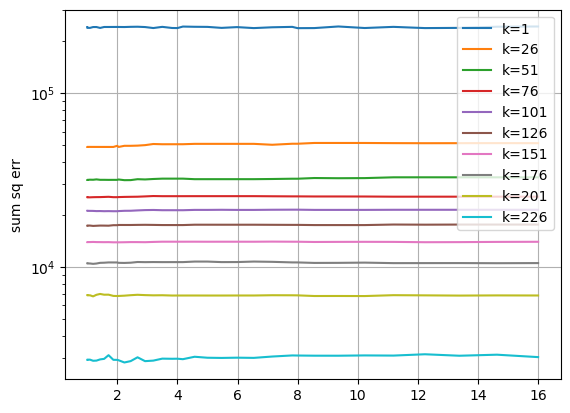

In [126]:
import matplotlib.pyplot as pl

pl.semilogy(lceigs_ks[sort_ks],sse[:,sort_ks].T)
pl.grid(1)
# pl.ylim([0, sse.max()*1.1])
pl.ylabel('sum sq err')
pl.legend([f'k={k}' for k in np.r_[:10]*25+1])
pl.show()

In [128]:
sse[4].mean() / sse[0].mean()

0.08820321175063353

from this, it doesn't seem to matter much which k is used, as long as we have enough modes. the 5th line, green here, is 101 modes, which retains only 8% of the sum squared error compared to using 1 mode.  This seems consistent with the connectome mode paper.

In [144]:

dF = run_data.T
pgain = pgains[2]
sse = [np.sum(np.square(dF))]
for k in tqdm.trange(1,150):
    pg = pgain[:, :k].T
    pgi = np.linalg.pinv(pg)
    dFr = (dF @ pgi) @ pg
    dFr /= dFr.ptp()
    # dFr *= dF.ptp()
    sse.append( np.sum(np.square(dFr - dF)) )
sse = np.array(sse)

100%|████████████████████████████████████████████████████████████████████████████████████| 149/149 [01:33<00:00,  1.59it/s]


In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
figure(figsize=(5,4))
plot(100-sse/sse.max()*100)
axhline(100-full_sse / sse.max()*100, color='r')
grid(1)
ylim([0,50])
xlabel('# of cortical harmonics')
ylabel('% variance reconstructed')
legend(('Harmonics', '8004 vertex cortex'))

NameError: name 'figure' is not defined

actually this fits the results from the previous analysis, so it seems fine.

In [133]:
igain = np.linalg.pinv(gain)

In [135]:
igain.shape, dF.shape

((8004, 246), (244670, 246))

In [137]:
dFr = ((dF @ igain.T) @ gain.T).T
dFr /= dFr.ptp()

In [138]:
full_sse = np.sum(np.square(dFr.T - dF))

In [142]:
full_sse/dF.shape[0], 'per time point'

(7.107777504446888, 'per time point')

now do that with Torch: the big matrix operations are much faster.

In [168]:
import torch

dF = torch.tensor(run_data.T).to('mps')

pgain = pgains[2]
to_mps = lambda x: torch.tensor(x.astype('f')).to('mps')

sses = []
for i in range(4):
    sse = [torch.sum(torch.square(dF))]
    for k in tqdm.trange(1,100):
        pg = pgains[i, :, :k].T
        pgi = np.linalg.pinv(pg)
        pg, pgi = to_mps(pg), to_mps(pgi)
        dFr = (dF @ pgi) @ pg
        dFr /= torch.max(dFr) - torch.min(dFr)
        # dFr *= dF.ptp()
        sse.append( torch.sum(torch.square(dFr - dF)) )
    sse = torch.tensor(sse)
    sses.append(sse)

100%|██████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:04<00:00, 21.17it/s]


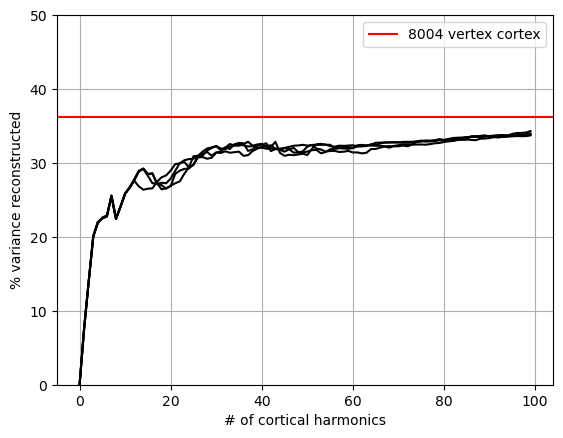

In [173]:
sses = np.array(sses)
axhline(100-full_sse / sses.T.max()*100, color='r')
plot(100-sses.T/sses.max()*100, 'k')
grid(1)
ylim([0,50])
xlabel('# of cortical harmonics')
ylabel('% variance reconstructed')
legend(('8004 vertex cortex', ))

## move data to spectral domain

So far, MEG data are in the time domain at sensor level.  A more compact representation easy for modeling purposes will be a short time Fourier or wavelet representation and in terms of mode coefficients.

- https://pytorch-wavelets.readthedocs.io/en/latest/dwt.html

This will reduce significantly the space taken up by the data and the compute required for modeling purposes.

In [148]:
run_data.shape, pgains.shape

((246, 244670), (36, 246, 230))

In [149]:
mode_ts = run_data.T @ pgains[5,:,:100]
mode_ts.shape

(244670, 100)

In [185]:
nfft = 4096

mode_wins = mode_ts[:len(mode_ts)//nfft*nfft].reshape((-1, nfft, 100))
mode_wins.shape

(59, 4096, 100)

In [186]:
modes_psd = np.mean(np.abs(np.fft.fft(mode_wins, axis=1)), axis=0)
modes_psd.shape

(4096, 100)

In [187]:
psd_fs = np.fft.fftfreq(nfft, 1/sfreq)
psd_fs[psd_fs>0][:10]

array([0.16556885, 0.3311377 , 0.49670655, 0.6622754 , 0.82784425,
       0.9934131 , 1.15898194, 1.32455079, 1.49011964, 1.65568849])

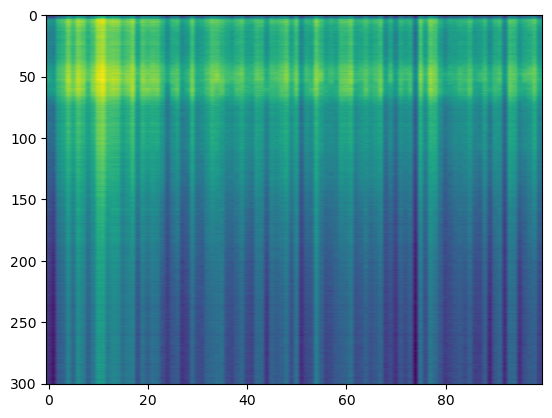

In [188]:
pl.imshow(np.log(modes_psd[ (psd_fs>0)*(psd_fs<50) ]), aspect='auto')

In [173]:
mode_ts.shape

(244670, 100)

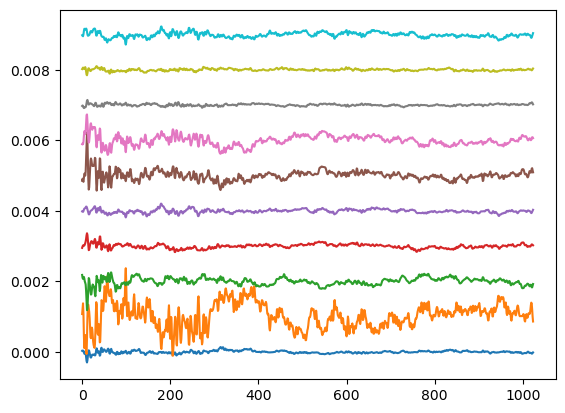

In [179]:
pl.plot(mode_ts[:1024,::10]+np.r_[:10]*1e-3)